In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  i

In [4]:
# 3
# Créer les générateurs d'images avec rescaling basic
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Créer les flux de données
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Pour test_data_gen, on va d'abord vérifier la structure
print(f"Contenu du dossier test: {os.listdir(test_dir)}")

# Créer le générateur de test avec une approche plus robuste
try:
    test_data_gen = test_image_generator.flow_from_directory(
        directory=PATH,  # Utiliser le PATH parent
        classes=['test'],  # Spécifier explicitement la classe test
        batch_size=1,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode=None,
        shuffle=False
    )
    print("Générateur de test créé avec succès")
except Exception as e:
    print(f"Erreur avec le générateur: {e}")
    print("Nous utiliserons une méthode alternative dans la cellule 10")


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Contenu du dossier test: ['48.jpg', '39.jpg', '7.jpg', '17.jpg', '18.jpg', '33.jpg', '35.jpg', '8.jpg', '27.jpg', '49.jpg', '4.jpg', '25.jpg', '3.jpg', '26.jpg', '38.jpg', '50.jpg', '16.jpg', '11.jpg', '22.jpg', '37.jpg', '24.jpg', '14.jpg', '12.jpg', '46.jpg', '41.jpg', '31.jpg', '19.jpg', '1.jpg', '40.jpg', '2.jpg', '42.jpg', '15.jpg', '32.jpg', '23.jpg', '5.jpg', '29.jpg', '44.jpg', '21.jpg', '.DS_Store', '36.jpg', '30.jpg', '9.jpg', '28.jpg', '13.jpg', '47.jpg', '45.jpg', '43.jpg', '6.jpg', '20.jpg', '34.jpg', '10.jpg']
Found 50 images belonging to 1 classes.
Générateur de test créé avec succès


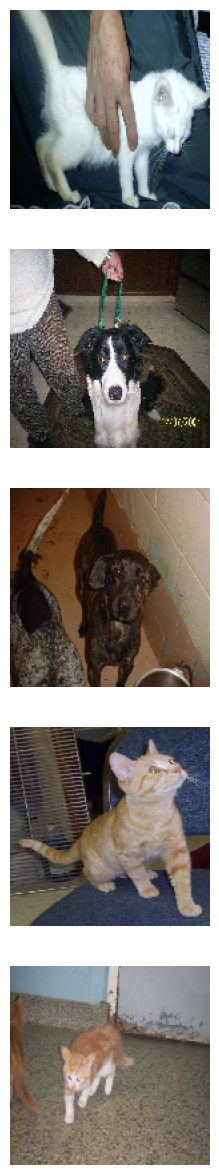

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
# 5
# Générateur avec augmentation de données pour réduire l'overfitting
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2000 images belonging to 2 classes.


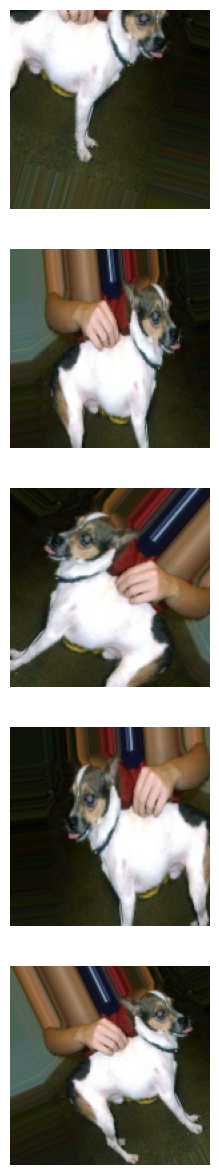

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [8]:
# 7
# Créer le modèle CNN
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 8
# Entraîner le modèle
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4708 - loss: 0.7651 - val_accuracy: 0.4989 - val_loss: 0.6956
Epoch 2/50
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5078 - loss: 0.6961

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5078 - loss: 0.6961 - val_accuracy: 0.4955 - val_loss: 0.6949
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 960ms/step - accuracy: 0.4891 - loss: 0.6973 - val_accuracy: 0.5301 - val_loss: 0.6924
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5938 - loss: 0.6918 - val_accuracy: 0.5279 - val_loss: 0.6922
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 956ms/step - accuracy: 0.5218 - loss: 0.6927 - val_accuracy: 0.5045 - val_loss: 0.6891
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5078 - loss: 0.6906 - val_accuracy: 0.5391 - val_loss: 0.6877
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 956ms/step - accuracy: 0.5267 - loss: 0.6900 - val_accuracy: 0.5536 - val_loss: 0.6768
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.6016 - loss: 0.6757 - val_accuracy: 0.5513 - val_loss: 0.6740
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 999ms/step - accuracy: 0.5782 - loss: 0.6706 - val_accuracy: 0.6060 - 

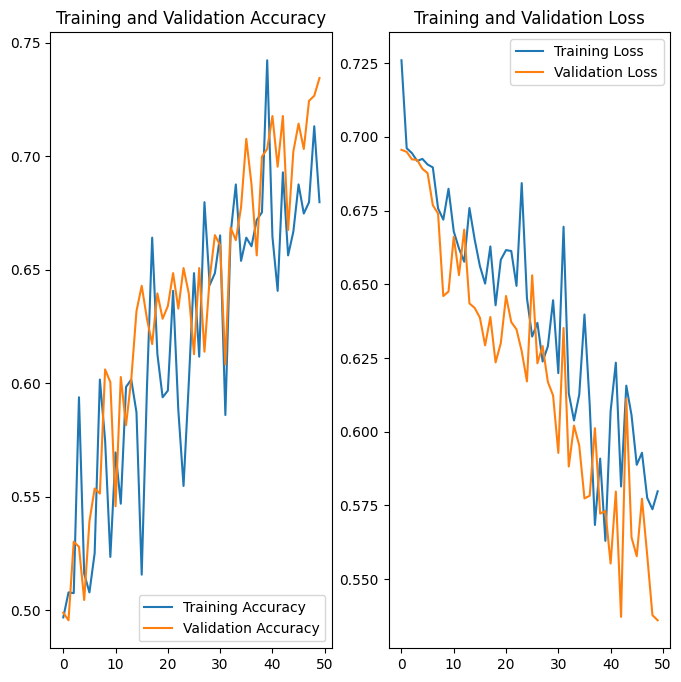

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nombre de fichiers de test trouvés: 50
Found 50 images belonging to 1 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


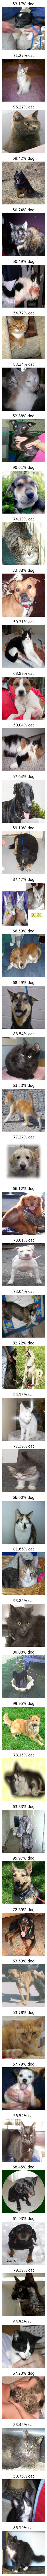

In [11]:
# Créer un nouveau générateur de test plus robuste
test_image_generator_fixed = ImageDataGenerator(rescale=1./255)

# Lister tous les fichiers dans le dossier test
import glob
test_files = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Nombre de fichiers de test trouvés: {len(test_files)}")

# Méthode 1: Si le générateur fonctionne
try:
    test_data_gen = test_image_generator_fixed.flow_from_directory(
        directory=PATH,  # Utiliser le PATH parent
        classes=['test'],  # Spécifier le dossier test comme classe
        batch_size=1,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode=None,
        shuffle=False
    )
    probabilities = model.predict(test_data_gen, steps=len(test_files))
    probabilities = probabilities.flatten()

except:
    # Méthode 2: Chargement manuel des images si le générateur échoue
    from tensorflow.keras.preprocessing import image

    test_images_manual = []
    probabilities = []

    for i, img_path in enumerate(sorted(test_files)):
        # Charger et préprocesser l'image
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Faire la prédiction
        pred = model.predict(img_array, verbose=0)
        probabilities.append(pred[0][0])
        test_images_manual.append(img_array[0])

        if i >= 49:  # Limiter à 50 images
            break

    probabilities = np.array(probabilities)
    test_images = np.array(test_images_manual)

# Si nous avons utilisé le générateur, obtenir les images
if 'test_images' not in locals():
    test_data_gen.reset()
    test_images = []
    for i in range(min(50, len(test_files))):
        img = next(test_data_gen)
        test_images.append(img[0])
    test_images = np.array(test_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)

# Afficher les résultats (limiter à 50 images maximum)
num_images = min(50, len(probabilities))
plotImages(test_images[:num_images], probabilities[:num_images])

In [12]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
